In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, CategoryEncoding, concatenate, StringLookup, Embedding, Flatten
from matplotlib import pyplot as plt

np.random.seed(42)

# Đọc dữ liệu từ file ad.csv
data = pd.read_csv("ad.csv")

# Đổi tên cột để phù hợp với tên feature trong mô hình gốc và target
data.rename(columns={
    'Age': 'user_age', 
    'Gender': 'user_gender',
    'Clicked on Ad': 'target_ctr',
}, inplace=True)

# Lựa chọn TẤT CẢ 9 features (4 số, 5 phân loại/text)
X = data[[
    'Daily Time Spent on Site', 'user_age', 'Area Income', 'Daily Internet Usage',
    'Ad Topic Line', 'City', 'user_gender', 'Country', 'Timestamp'
]]
y = data['target_ctr'].values.astype(np.float32) # Biến mục tiêu

# Chia 70% train, 15% val, 15% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, random_state=42)

y_train_arr = y_train.astype('float32')
y_val_arr = y_val.astype('float32')
y_test_arr = y_test.astype('float32') # Chuẩn bị targets cho tập test

print(f"Dữ liệu ad.csv đã được tải với {len(data)} mẫu.")
print(f"Các features mới được sử dụng: {X.columns.tolist()}")
print(f"Kích thước tập Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Dữ liệu ad.csv đã được tải với 10000 mẫu.
Các features mới được sử dụng: ['Daily Time Spent on Site', 'user_age', 'Area Income', 'Daily Internet Usage', 'Ad Topic Line', 'City', 'user_gender', 'Country', 'Timestamp']
Kích thước tập Train: 6999, Validation: 1501, Test: 1500


In [2]:
# --- 2. XÂY DỰNG CÁC LỚP TIỀN XỬ LÝ VÀ CHẠY ADAPT ---

# a) Features Số: Chuẩn hóa (4x Normalization)
time_norm_layer = Normalization(axis=None)
time_norm_layer.adapt(X_train['Daily Time Spent on Site'].to_numpy().astype('float32').reshape(-1, 1))

age_norm_layer = Normalization(axis=None)
age_norm_layer.adapt(X_train['user_age'].to_numpy().astype('float32').reshape(-1, 1))

income_norm_layer = Normalization(axis=None)
income_norm_layer.adapt(X_train['Area Income'].to_numpy().astype('float32').reshape(-1, 1))

internet_norm_layer = Normalization(axis=None)
internet_norm_layer.adapt(X_train['Daily Internet Usage'].to_numpy().astype('float32').reshape(-1, 1))


# b) Features Phân loại/Text: StringLookup (5x)
# Định nghĩa kích thước từ vựng tối đa cho các lớp StringLookup (đã được làm tròn)
VOCAB_SIZE_TOPIC = 10000 
VOCAB_SIZE_CITY = 10000 
VOCAB_SIZE_COUNTRY = 300 
VOCAB_SIZE_TIMESTAMP = 10000 

# 1. Gender (Low Cardinality -> One-Hot)
gender_lookup_layer = StringLookup(output_mode="int")
gender_lookup_layer.adapt(X_train['user_gender'].to_numpy().astype(str))
# gender_encoding_layer sẽ được định nghĩa trong Code Cell 3

# 2. Ad Topic Line (High Cardinality -> Embedding)
topic_lookup_layer = StringLookup(max_tokens=VOCAB_SIZE_TOPIC, output_mode="int")
topic_lookup_layer.adapt(X_train['Ad Topic Line'].to_numpy().astype(str))

# 3. City (High Cardinality -> Embedding)
city_lookup_layer = StringLookup(max_tokens=VOCAB_SIZE_CITY, output_mode="int")
city_lookup_layer.adapt(X_train['City'].to_numpy().astype(str))

# 4. Country (High Cardinality -> Embedding)
country_lookup_layer = StringLookup(max_tokens=VOCAB_SIZE_COUNTRY, output_mode="int")
country_lookup_layer.adapt(X_train['Country'].to_numpy().astype(str))

# 5. Timestamp (High Cardinality/Time -> Embedding)
timestamp_lookup_layer = StringLookup(max_tokens=VOCAB_SIZE_TIMESTAMP, output_mode="int")
timestamp_lookup_layer.adapt(X_train['Timestamp'].to_numpy().astype(str))

In [3]:
# --- 3. ĐỊNH NGHĨA VÀ BIÊN DỊCH MÔ HÌNH (Sử dụng 9 features + Embedding) ---

# Định nghĩa tất cả 9 inputs
# Features Số (4)
input_time = keras.Input(shape=(1,), name="Daily Time Spent on Site", dtype='float32')
input_age = keras.Input(shape=(1,), name="user_age", dtype='float32')
input_income = keras.Input(shape=(1,), name="Area Income", dtype='float32')
input_internet = keras.Input(shape=(1,), name="Daily Internet Usage", dtype='float32')
# Features Phân loại/Text (5)
input_gender = keras.Input(shape=(1,), dtype="string", name="user_gender")
input_topic = keras.Input(shape=(1,), dtype="string", name="Ad Topic Line")
input_city = keras.Input(shape=(1,), dtype="string", name="City")
input_country = keras.Input(shape=(1,), dtype="string", name="Country")
input_timestamp = keras.Input(shape=(1,), dtype="string", name="Timestamp")


# Áp dụng tiền xử lý/Embedding

# 1. Numerical Features (4x Normalization)
time_features = time_norm_layer(input_time)
age_features = age_norm_layer(input_age)
income_features = income_norm_layer(input_income)
internet_features = internet_norm_layer(input_internet)

# 2. Categorical Features (5x)

# Gender (One-Hot)
gender_encoding_layer = CategoryEncoding(
    num_tokens=gender_lookup_layer.vocabulary_size(), 
    output_mode="one_hot"
)
gender_features = gender_encoding_layer(gender_lookup_layer(input_gender))

# Topic (Embedding)
topic_indices = topic_lookup_layer(input_topic)
topic_embedding = Embedding(input_dim=VOCAB_SIZE_TOPIC, output_dim=64)(topic_indices)
topic_features = Flatten()(topic_embedding)

# City (Embedding)
city_indices = city_lookup_layer(input_city)
city_embedding = Embedding(input_dim=VOCAB_SIZE_CITY, output_dim=64)(city_indices)
city_features = Flatten()(city_embedding)

# Country (Embedding)
country_indices = country_lookup_layer(input_country)
country_embedding = Embedding(input_dim=VOCAB_SIZE_COUNTRY, output_dim=32)(country_indices)
country_features = Flatten()(country_embedding)

# Timestamp (Embedding)
timestamp_indices = timestamp_lookup_layer(input_timestamp)
timestamp_embedding = Embedding(input_dim=VOCAB_SIZE_TIMESTAMP, output_dim=64)(timestamp_indices)
timestamp_features = Flatten()(timestamp_embedding)

# Kết hợp TẤT CẢ features
all_features = concatenate([
    time_features, age_features, income_features, internet_features, # 4 số
    gender_features, # 1 OH
    topic_features, city_features, country_features, timestamp_features # 4 Embedding
])

# Kiến trúc mạng (Được điều chỉnh cho input lớn hơn)
x = layers.Dense(128, activation="relu")(all_features)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)

output_prob = layers.Dense(1, activation="sigmoid", name="click_probability")(x)
model = keras.Model(inputs=[
    input_time, input_age, input_income, input_internet, 
    input_gender, input_topic, input_city, input_country, input_timestamp
], outputs=output_prob)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy", 
    metrics=[keras.metrics.AUC(name='roc_auc')]
)

# --- IN RA CẤU TRÚC MÔ HÌNH ---
print("\n--- CẤU TRÚC MÔ HÌNH 9 FEATURES VÀ SỐ LƯỢNG THAM SỐ ---")
model.summary()


--- CẤU TRÚC MÔ HÌNH 9 FEATURES VÀ SỐ LƯỢNG THAM SỐ ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Ad Topic Line (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ City (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Country (InputLayer)          │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Timestamp (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_gender (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ string_lookup_1               │ (None, 1)                 │               0 │ Ad Topic Line[0][0]        │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ string_lookup_2               │ (None, 1)                 │               0 │ City[0][0]                 │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ string_lookup_3               │ (None, 1)                 │               0 │ Country[0][0]              │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ string_lookup_4               │ (None, 1)                 │               0 │ Timestamp[0][0]            │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Daily Time Spent on Site      │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_age (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Area Income (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Daily Internet Usage          │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ string_lookup (StringLookup)  │ (None, 1)                 │               0 │ user_gender[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,967,629 (7.51 MB)

 Trainable params: 1,967,617 (7.51 MB)

 Non-trainable params: 12 (64.00 B)

In [4]:
# --- 4. HUẤN LUYỆN MÔ HÌNH ---

def prepare_data_dict(X_df):
    """Chuyển đổi dữ liệu Pandas/NumPy sang dictionary TensorFlow Tensors cho tất cả 9 inputs"""
    data_dict = {
        'Daily Time Spent on Site': tf.convert_to_tensor(X_df['Daily Time Spent on Site'].values.astype('float32')),
        'user_age': tf.convert_to_tensor(X_df['user_age'].values.astype('float32')), 
        'Area Income': tf.convert_to_tensor(X_df['Area Income'].values.astype('float32')),
        'Daily Internet Usage': tf.convert_to_tensor(X_df['Daily Internet Usage'].values.astype('float32')),
        
        'user_gender': tf.convert_to_tensor(X_df['user_gender'].values.astype(str), dtype=tf.string), 
        'Ad Topic Line': tf.convert_to_tensor(X_df['Ad Topic Line'].values.astype(str), dtype=tf.string),
        'City': tf.convert_to_tensor(X_df['City'].values.astype(str), dtype=tf.string),
        'Country': tf.convert_to_tensor(X_df['Country'].values.astype(str), dtype=tf.string),
        'Timestamp': tf.convert_to_tensor(X_df['Timestamp'].values.astype(str), dtype=tf.string),
    }
    return data_dict

train_data_dict = prepare_data_dict(X_train)
val_data_dict = prepare_data_dict(X_val)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

print("\n--- GIAI ĐOẠN PHÁT TRIỂN: HUẤN LUYỆN MÔ HÌNH VỚI 9 FEATURES ---")

history = model.fit(
    train_data_dict, y_train_arr,
    epochs=50,
    batch_size=256,
    validation_data=(val_data_dict, y_val_arr),
    callbacks=callbacks,
    verbose=1
)


--- GIAI ĐOẠN PHÁT TRIỂN: HUẤN LUYỆN MÔ HÌNH VỚI 9 FEATURES ---
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6015 - roc_auc: 0.7679 - val_loss: 0.4596 - val_roc_auc: 0.8818
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3387 - roc_auc: 0.9318 - val_loss: 0.2659 - val_roc_auc: 0.9582
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2145 - roc_auc: 0.9716 - val_loss: 0.2700 - val_roc_auc: 0.9607
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1803 - roc_auc: 0.9792 - val_loss: 0.2743 - val_roc_auc: 0.9599
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1606 - roc_auc: 0.9835 - val_loss: 0.2926 - val_roc_auc: 0.9580
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1489 - roc_auc: 0.9853 - val_loss: 0.3080 - val_roc_auc: 0.9563
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1354 - roc_auc: 0.9879 - val_loss: 0.3345 - val_roc_auc: 0.9520
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1295 -


--- GIAI ĐOẠN TRIỂN KHAI: ĐÁNH GIÁ CUỐI CÙNG ---
Final Test Loss: 0.2354
Final Test ROC AUC: 0.9668

--- TRỰC QUAN HÓA KẾT QUẢ HUẤN LUYỆN ---


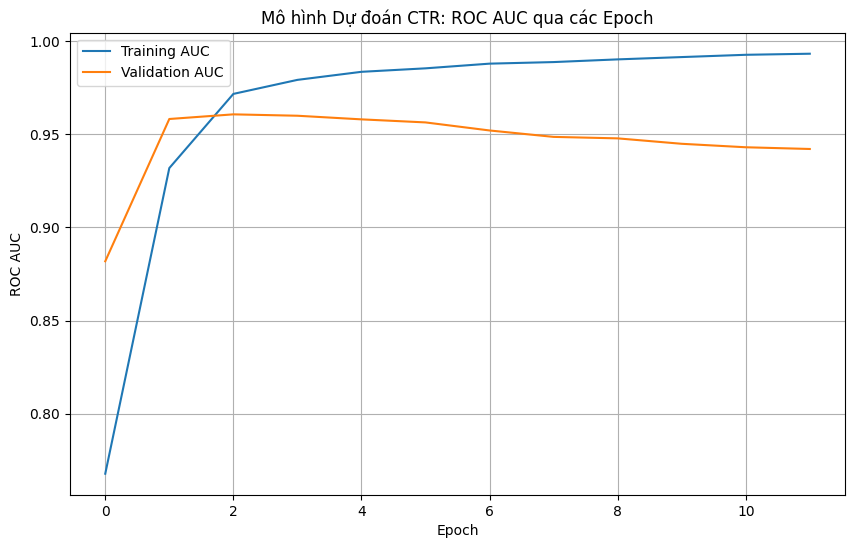

In [5]:
test_data_dict = prepare_data_dict(X_test)
final_results = model.evaluate(test_data_dict, y_test_arr, verbose=0)
print("\n--- GIAI ĐOẠN TRIỂN KHAI: ĐÁNH GIÁ CUỐI CÙNG ---")
print(f"Final Test Loss: {final_results[0]:.4f}")
print(f"Final Test ROC AUC: {final_results[1]:.4f}")

# --- 5. TRỰC QUAN HÓA KẾT QUẢ ---
print("\n--- TRỰC QUAN HÓA KẾT QUẢ HUẤN LUYỆN ---")

# Trực quan hóa ROC AUC (Hiệu suất)
plt.figure(figsize=(10, 6))
plt.plot(history.history['roc_auc'], label='Training AUC')
plt.plot(history.history['val_roc_auc'], label='Validation AUC')
plt.title('Mô hình Dự đoán CTR: ROC AUC qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from tensorflow.keras import regularizers

# --- 1. ĐỊNH NGHĨA INPUTS VÀ TIỀN XỬ LÝ (Sử dụng 9 features) ---

# Định nghĩa tất cả 9 inputs
# Features Số (4)
input_time = keras.Input(shape=(1,), name="Daily Time Spent on Site", dtype='float32')
input_age = keras.Input(shape=(1,), name="user_age", dtype='float32')
input_income = keras.Input(shape=(1,), name="Area Income", dtype='float32')
input_internet = keras.Input(shape=(1,), name="Daily Internet Usage", dtype='float32')
# Features Phân loại/Text (5)
input_gender = keras.Input(shape=(1,), dtype="string", name="user_gender")
input_topic = keras.Input(shape=(1,), dtype="string", name="Ad Topic Line")
input_city = keras.Input(shape=(1,), dtype="string", name="City")
input_country = keras.Input(shape=(1,), dtype="string", name="Country")
input_timestamp = keras.Input(shape=(1,), dtype="string", name="Timestamp")

# Áp dụng tiền xử lý/Embedding (Sử dụng các layer đã adapt từ Code Cell 2)
# Numerical Features (4x Normalization)
time_features = time_norm_layer(input_time)
age_features = age_norm_layer(input_age)
income_features = income_norm_layer(input_income)
internet_features = internet_norm_layer(input_internet)

# Categorical Features (5x)
# Gender (One-Hot)
gender_encoding_layer = CategoryEncoding(
    num_tokens=gender_lookup_layer.vocabulary_size(), 
    output_mode="one_hot"
)
gender_features = gender_encoding_layer(gender_lookup_layer(input_gender))

# Embedding Features (4x Embedding + Flatten)
topic_indices = topic_lookup_layer(input_topic)
topic_embedding = Embedding(input_dim=VOCAB_SIZE_TOPIC, output_dim=64)(topic_indices)
topic_features = Flatten()(topic_embedding)

city_indices = city_lookup_layer(input_city)
city_embedding = Embedding(input_dim=VOCAB_SIZE_CITY, output_dim=64)(city_indices)
city_features = Flatten()(city_embedding)

country_indices = country_lookup_layer(input_country)
country_embedding = Embedding(input_dim=VOCAB_SIZE_COUNTRY, output_dim=32)(country_indices)
country_features = Flatten()(country_embedding)

timestamp_indices = timestamp_lookup_layer(input_timestamp)
timestamp_embedding = Embedding(input_dim=VOCAB_SIZE_TIMESTAMP, output_dim=64)(timestamp_indices)
timestamp_features = Flatten()(timestamp_embedding)

# Kết hợp TẤT CẢ features
all_features = concatenate([
    time_features, age_features, income_features, internet_features, 
    gender_features,
    topic_features, city_features, country_features, timestamp_features
])

# --- 2. KIẾN TRÚC MÔ HÌNH VỚI REGULARIZATION MỚI ---

# Sử dụng L2 Regularizer
l2_reg = regularizers.l2(0.001) # Giảm hệ số L2 xuống 0.001 vì mô hình lớn hơn

# Lớp Dense 1: Áp dụng L2 Regularization (0.001)
x = layers.Dense(128, activation="relu", 
                  kernel_regularizer=l2_reg)(all_features)
                  
# Dropout: Tỷ lệ loại bỏ (0.5)
x = layers.Dropout(0.5)(x) 

# Lớp Dense 2: Áp dụng L2 Regularization (0.001)
x = layers.Dense(64, activation="relu", 
                  kernel_regularizer=l2_reg)(x)

# Dropout: Thêm Dropout thứ hai để chống quá khớp hiệu quả hơn
x = layers.Dropout(0.5)(x)

output_prob = layers.Dense(1, activation="sigmoid", name="click_probability")(x)

# Cập nhật danh sách inputs của Model (9 inputs)
model_reg = keras.Model(inputs=[
    input_time, input_age, input_income, input_internet, 
    input_gender, input_topic, input_city, input_country, input_timestamp
], outputs=output_prob)

model_reg.compile(
    optimizer="adam",
    loss="binary_crossentropy", 
    metrics=[keras.metrics.AUC(name='roc_auc')]
)

print("\n--- CẤU TRÚC MÔ HÌNH 9 FEATURES ĐÃ TĂNG CƯỜNG REGULARIZATION ---")
model_reg.summary()

# --- 3. HUẤN LUYỆN MÔ HÌNH MỚI ---

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

print("\nBắt đầu huấn luyện mô hình đã regularized (9 features)...")

history_reg = model_reg.fit(
    train_data_dict, y_train_arr,
    epochs=50,
    batch_size=256,
    validation_data=(val_data_dict, y_val_arr),
    callbacks=callbacks,
    verbose=1
)


--- CẤU TRÚC MÔ HÌNH 9 FEATURES ĐÃ TĂNG CƯỜNG REGULARIZATION ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Ad Topic Line (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ City (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Country (InputLayer)          │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Timestamp (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_gender (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ string_lookup_1               │ (None, 1)                 │               0 │ Ad Topic Line[0][0]        │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ string_lookup_2               │ (None, 1)                 │               0 │ City[0][0]                 │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ string_lookup_3               │ (None, 1)                 │               0 │ Country[0][0]              │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ string_lookup_4               │ (None, 1)                 │               0 │ Timestamp[0][0]            │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Daily Time Spent on Site      │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_age (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Area Income (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Daily Internet Usage          │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ string_lookup (StringLookup)  │ (None, 1)                 │               0 │ user_gender[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,967,629 (7.51 MB)

 Trainable params: 1,967,617 (7.51 MB)

 Non-trainable params: 12 (64.00 B)


Bắt đầu huấn luyện mô hình đã regularized (9 features)...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.8445 - roc_auc: 0.7127 - val_loss: 0.7212 - val_roc_auc: 0.8180
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6248 - roc_auc: 0.8657 - val_loss: 0.4737 - val_roc_auc: 0.9362
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4156 - roc_auc: 0.9516 - val_loss: 0.3866 - val_roc_auc: 0.9605
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3320 - roc_auc: 0.9697 - val_loss: 0.3587 - val_roc_auc: 0.9617
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2829 - roc_auc: 0.9771 - val_loss: 0.3515 - val_roc_auc: 0.9609
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2550 - roc_auc: 0.9804 - val_loss: 0.3498 - val_roc_auc: 0.9605
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2364 - roc_auc: 0.9821 - val_loss: 0.3488 - val_roc_auc: 0.9594
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2197 - roc

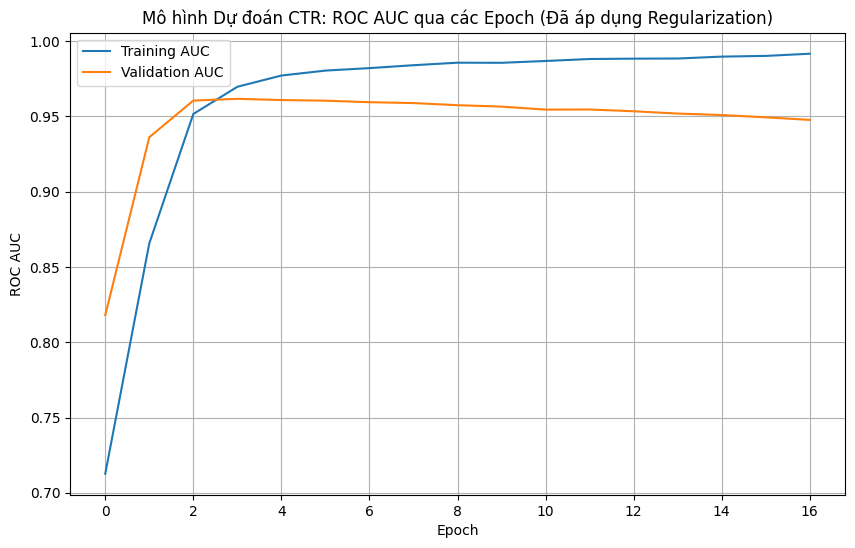

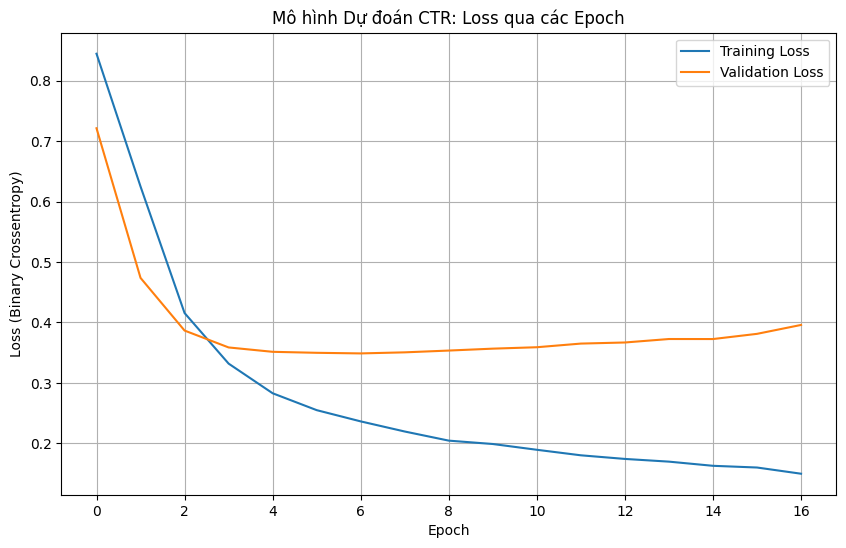

In [8]:
import matplotlib.pyplot as plt

# --- Trực quan hóa ROC AUC (Hiệu suất) ---
plt.figure(figsize=(10, 6))

# Lấy dữ liệu ROC AUC từ đối tượng history (history_reg)
plt.plot(history_reg.history['roc_auc'], label='Training AUC')
plt.plot(history_reg.history['val_roc_auc'], label='Validation AUC')

plt.title('Mô hình Dự đoán CTR: ROC AUC qua các Epoch (Đã áp dụng Regularization)')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)
plt.show()

# --- Trực quan hóa Loss (Mất mát) ---
plt.figure(figsize=(10, 6))
plt.plot(history_reg.history['loss'], label='Training Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Mô hình Dự đoán CTR: Loss qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)
plt.show()